# Welcome to Passion!
Passion is a model that can detection anomaly using different methods (Both supervised and unsupervised) <br>

1. The goal for this project is to study the difference between different anomnaly detection model, and to   <br>
 find the state of art method for detecting anomaly in real world data<br>
2. Evaluate the results based on this :real server data+ https://www.kaggle.com/sohier/30-years-of-european-wind-generation + https://github.com/numenta/NAB <br>
3. Also use real data generated from server.
4. The model has the following fuctions: <br>
    a. Visualize the input data. Help the user to find critical features within the inputs. <br>
    b. Give user options to choose different models that are suitable for different circumstances. <br>
    c. Evaluate the performance based on the rules in this link https://github.com/numenta/NAB <br>
    d. Save model. Easy to be appplied to other dataset. <br>

5. This is the very beginning of the process. Still need to do a lot of works!




# What's new in version 4.1
1. Add LSTM based model (Also include HMM features)
2. Add more real server data
3. Add 1d CNN
4. Add GRU
5. Add a new fusion model 
6. Add MLSTM-FCN: https://arxiv.org/pdf/1709.05206.pdf

In [1]:
# import packages 


from matplotlib.pylab import rc
import torch
from scipy.stats import chisquare
from scipy.stats import pearsonr 
import pickle
import pandas as pd
import datetime
import matplotlib
import tensorflow as tf
import sklearn
import math
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
import copy
import scipy
import datetime
import time
import os
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import gc

plot_path = "plots/"


In [2]:

# Real server data

root_path = "Data/Ant_202007/"


cif = pd.read_json(root_path+'cif.json', orient='index')
paycore = pd.read_json(root_path+'paycore.json', orient='index')
paydecision = pd.read_json(root_path+'paydecision.json', orient='index')
paydecision2 = pd.read_json(root_path+'paydecision2.json', orient='index')
paydecision3 = pd.read_json(root_path+'paydecision3.json', orient='index')

df = pd.DataFrame()
df["time_stamp"] = cif.index
df["cif"] = cif[0].values
df["paycore"] = paycore[0].values
df["paydecision"] = paydecision[0].values
df["paydecision2"] = paydecision2[0].values
df["paydecision3"] = paydecision3[0].values

# Optional
if False:
    df.to_csv(root_path+"fusion.csv")

    
# convert time stamp
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
names_array = np.array(df.keys()[1:],dtype="str")
os.listdir(root_path)




['.ipynb_checkpoints',
 'cif.json',
 'fusion.csv',
 'paycore.json',
 'paydecision.json',
 'paydecision2.json',
 'paydecision3.json']

In [3]:

# calculate previous hour high low:
# convert to seconds
temp = df['time_stamp'] - min(df['time_stamp'])
temp = temp.dt.total_seconds().astype(int)
df["hours"] = temp//3600

h_max = max(df["hours"])+1

for n in range(len(names_array)):
    df[names_array[n]+"_open"] = df[names_array[n]]
    df[names_array[n]+"_close"] = df[names_array[n]]
    df[names_array[n]+"_max"] = df[names_array[n]]
    df[names_array[n]+"_min"] = df[names_array[n]]

for j in range(1,h_max):
    mask_j = df["hours"]==j-1
    max_val = df[mask_j][names_array].max(axis=0).values
    min_val = df[mask_j][names_array].max(axis=0).values
    open_val = df[mask_j][names_array].values[0,:]
    close_val = df[mask_j][names_array].values[-1,:]
    mask_i = df["hours"]==j
    r = df[mask_i][names_array].shape[0]
    df.loc[mask_i,[r+"_open" for r in names_array]] = np.tile(open_val,(r,1))
    df.loc[mask_i,[r+"_close" for r in names_array]] = np.tile(close_val,(r,1))
    
    df.loc[mask_i,[r+"_max" for r in names_array]] = np.tile(max_val,(r,1))
    df.loc[mask_i,[r+"_min" for r in names_array]] = np.tile(min_val,(r,1))
    
    



In [4]:
df

,time_stamp,cif,paycore,paydecision,paydecision2,paydecision3,hours,cif_open,cif_close,cif_max,...,paydecision_max,paydecision_min,paydecision2_open,paydecision2_close,paydecision2_max,paydecision2_min,paydecision3_open,paydecision3_close,paydecision3_max,paydecision3_min
0,2020-06-03 16:00:00,5230362.0,1742333,810511,894642,254995,0,5230362.0,5230362.0,5230362.0,...,810511.0,810511.0,894642.0,894642.0,894642.0,894642.0,254995.0,254995.0,254995.0,254995.0
1,2020-06-03 16:01:00,5430718.0,1250771,732380,720773,213345,0,5430718.0,5430718.0,5430718.0,...,732380.0,732380.0,720773.0,720773.0,720773.0,720773.0,213345.0,213345.0,213345.0,213345.0
2,2020-06-03 16:02:00,5352478.0,998340,715939,691644,163959,0,5352478.0,5352478.0,5352478.0,...,715939.0,715939.0,691644.0,691644.0,691644.0,691644.0,163959.0,163959.0,163959.0,163959.0
3,2020-06-03 16:03:00,5247694.0,971876,701533,669921,165899,0,5247694.0,5247694.0,5247694.0,...,701533.0,701533.0,669921.0,669921.0,669921.0,669921.0,165899.0,165899.0,165899.0,165899.0
4,2020-06-03 16:04:00,5197260.0,926380,685236,649162,167605,0,5197260.0,5197260.0,5197260.0,...,685236.0,685236.0,649162.0,649162.0,649162.0,649162.0,167605.0,167605.0,167605.0,167605.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41756,2020-07-02 15:56:00,4573918.0,681739,549321,490459,142306,695,8358653.0,6482250.0,8439483.0,...,1072625.0,1072625.0,987553.0,771209.0,990662.0,990662.0,261211.0,218522.0,293880.0,293880.0
41757,2020-07-02 15:57:00,4562205.0,675371,546406,489352,137810,695,8358653.0,6482250.0,8439483.0,...,1072625.0,1072625.0,987553.0,771209.0,990662.0,990662.0,261211.0,218522.0,293880.0,293880.0
41758,2020-07-02 15:58:00,4546905.0,668348,539951,486135,128817,695,8358653.0,6482250.0,8439483.0,...,1072625.0,1072625.0,987553.0,771209.0,990662.0,990662.0,261211.0,218522.0,293880.0,293880.0
41759,2020-07-02 15:59:00,4544560.0,663263,535808,481801,131527,695,8358653.0,6482250.0,8439483.0,...,1072625.0,1072625.0,987553.0,771209.0,990662.0,990662.0,261211.0,218522.0,293880.0,293880.0


# LSTM based model
This time with high+low+on+off for 1d data

In [28]:
df["minutes"]=df["time_stamp"].dt.hour*1440+df["time_stamp"].dt.hour*60+df["time_stamp"].dt.minute
# hyper-parameters:
# delta_t in minute,try a day first,output 5 dimensions
delta_t = 1440
n_epoch=10
n_cell = 50
# predict 1 minute for now
N_output=1
index_name= 0

checkpoint_path = "LSTM/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

min_max_scaler = preprocessing.StandardScaler()

# min-max scaler
np_scaled = min_max_scaler.fit_transform(df[names_array])

df_scaled = pd.DataFrame(np_scaled,columns=names_array)


X = np.zeros((df_scaled.shape[0]-delta_t,delta_t,1),dtype=float)
y = df_scaled[names_array[index_name]][delta_t:]
    
for i in range(len(y)):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = np.atleast_2d(df_scaled[i:i+delta_t][names_array[index_name]].values).T

# split train test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

model = tf.keras.Sequential([
  tf.keras.layers.LSTM(n_cell,input_shape=(X_train.shape[1],X_train.shape[2])),  # must declare input shape
  tf.keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer='adam')
#model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



Prepare data 0.00 percent
Prepare data 24.80 percent
Prepare data 49.60 percent
Prepare data 74.40 percent
Prepare data 99.20 percent


In [29]:

history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)




Epoch 1/10
441/441 [==============================] - ETA: 0s - loss: 0.1203
Epoch 00001: saving model to LSTM/cp.ckpt
441/441 [==============================] - 47s 106ms/step - loss: 0.1203 - val_loss: 0.0401
Epoch 2/10
441/441 [==============================] - ETA: 0s - loss: 0.0661
Epoch 00002: saving model to LSTM/cp.ckpt
441/441 [==============================] - 46s 105ms/step - loss: 0.0661 - val_loss: 0.0622
Epoch 3/10
441/441 [==============================] - ETA: 0s - loss: 0.0537
Epoch 00003: saving model to LSTM/cp.ckpt
441/441 [==============================] - 46s 105ms/step - loss: 0.0537 - val_loss: 0.0369
Epoch 4/10
441/441 [==============================] - ETA: 0s - loss: 0.0422
Epoch 00004: saving model to LSTM/cp.ckpt
441/441 [==============================] - 46s 105ms/step - loss: 0.0422 - val_loss: 0.0269
Epoch 5/10
441/441 [==============================] - ETA: 0s - loss: 0.0365
Epoch 00005: saving model to LSTM/cp.ckpt
441/441 [============================

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


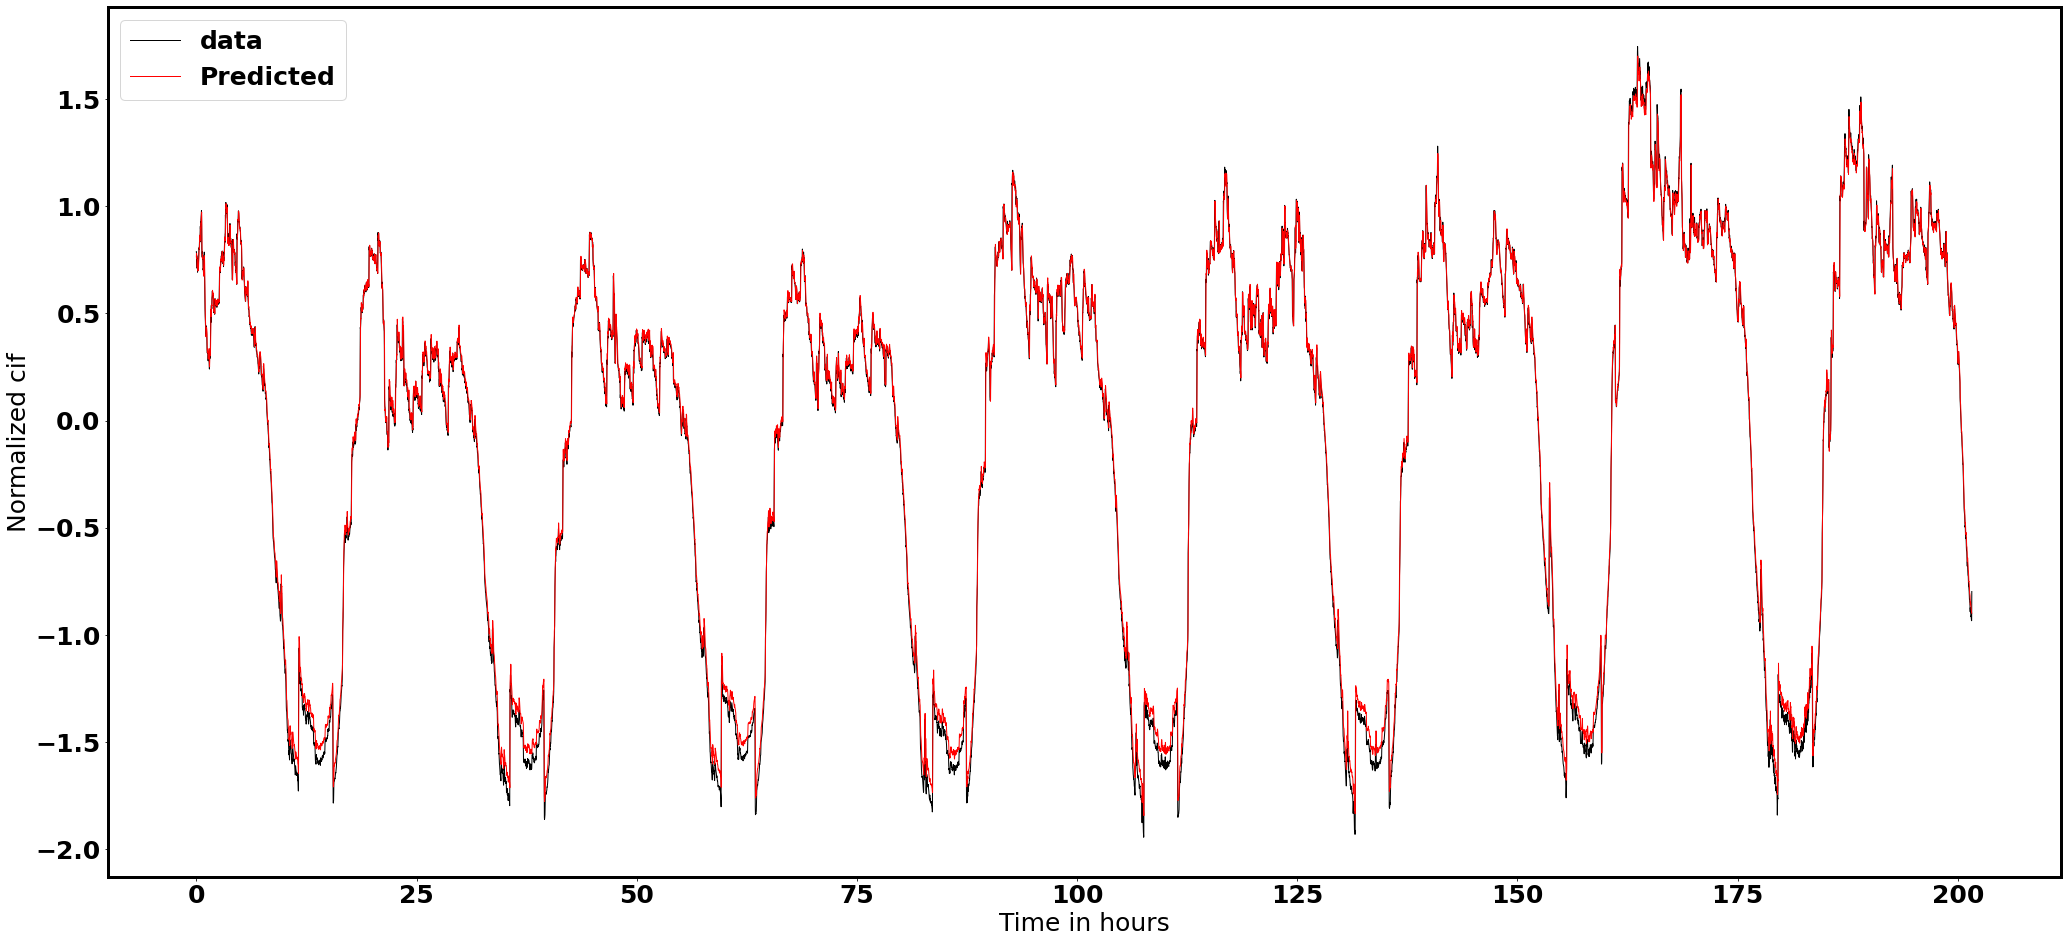

In [30]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
y_pre = model.predict(X_test)
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"k",label="data",alpha=1,linewidth=1)
plt.plot(timeline/60,y_pre[:,0],"r",label="Predicted",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "LSTM_results_1D" + ".png"

fig.savefig(save_path, dpi=150)





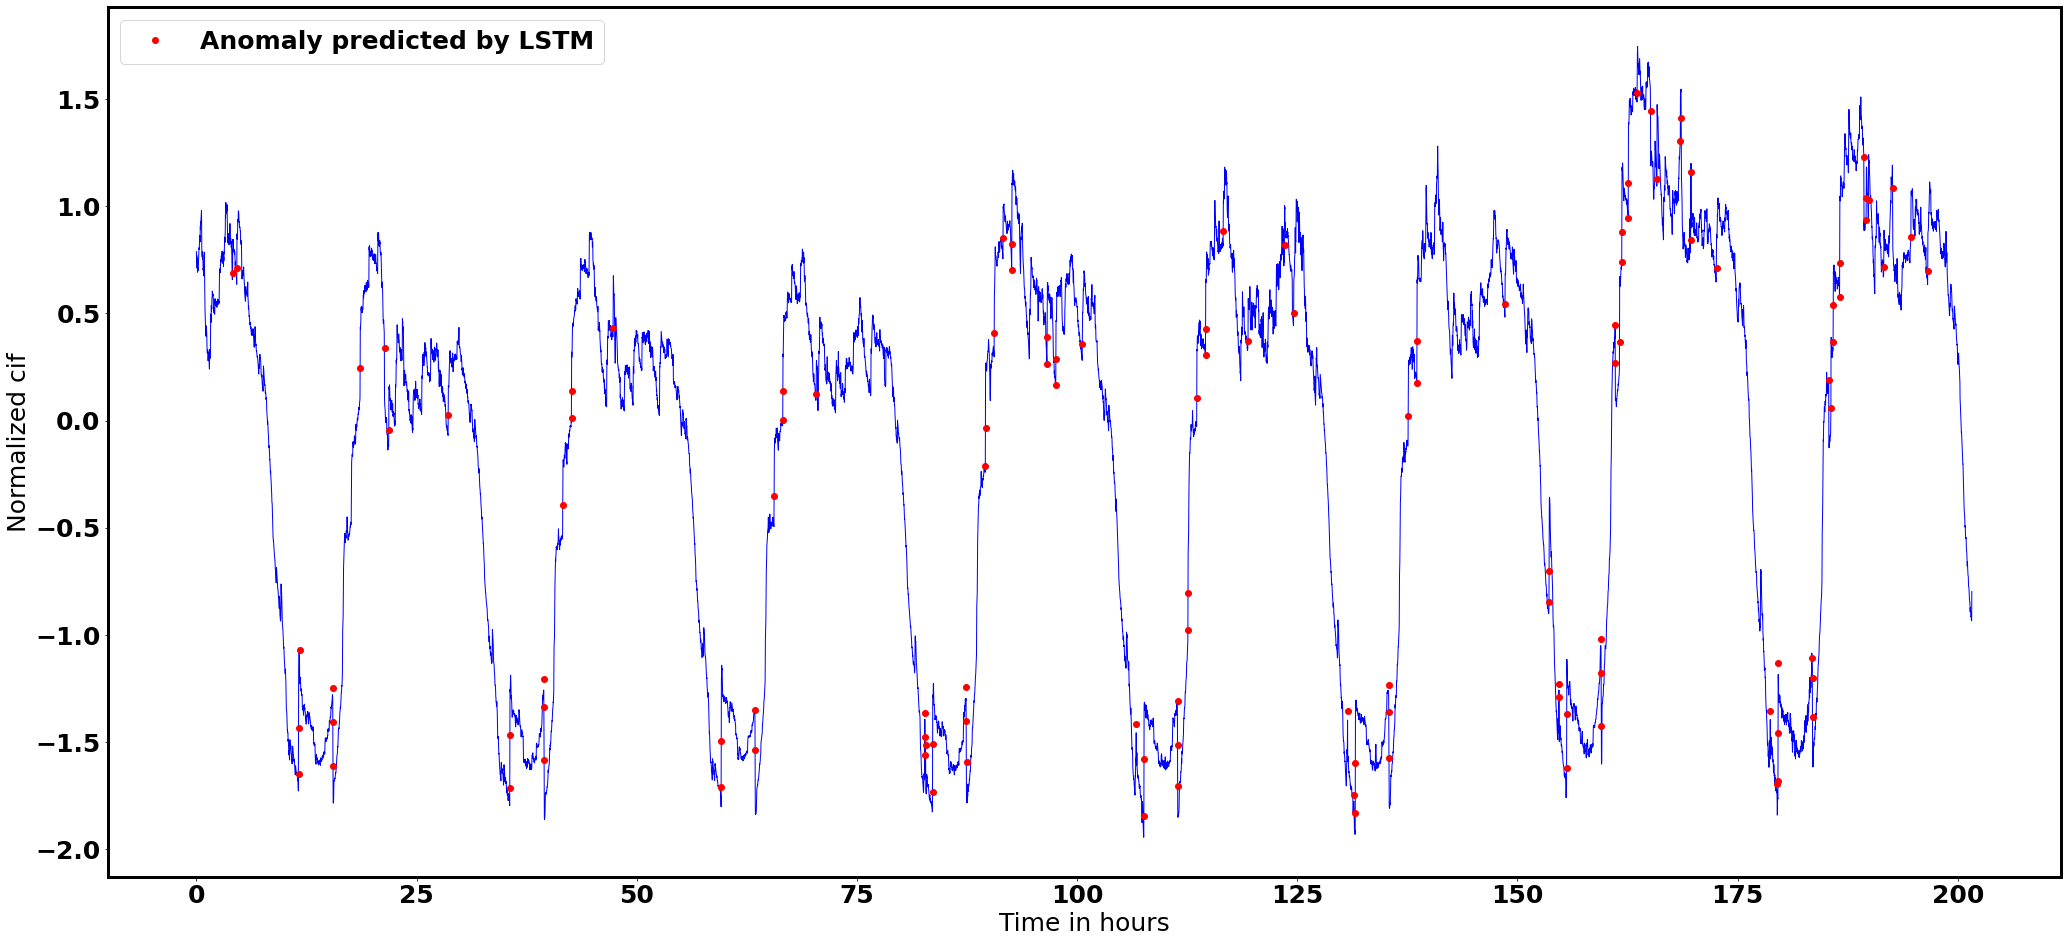

In [33]:
# Predict Anomaly using this rule: Bigger difference between data and prediction means anomaly

diff = y_test-y_pre[:,0]
anomaly_ratio = 0.01
mask = abs(diff)>np.nanpercentile(abs(diff),100-100*anomaly_ratio)



font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"b",alpha=1,linewidth=1)
plt.plot(timeline[mask]/60,y_test[mask],"ro",label="Anomaly predicted by LSTM",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "LSTM_anomaly_prediction_1D" + ".png"

fig.savefig(save_path, dpi=150)






# 1D CNN:
Baseline

In [49]:
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

df["minutes"]=df["time_stamp"].dt.hour*1440+df["time_stamp"].dt.hour*60+df["time_stamp"].dt.minute
# hyper-parameters:
# delta_t in minute,try a day first,output 5 dimensions
delta_t = 1440
n_epoch=50
index_name= 0
rate_dropout=0.3
# predict 1 minute for now
N_output=1

checkpoint_path = "CNN_1D/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)



In [50]:
min_max_scaler = preprocessing.StandardScaler()

# min-max scaler
np_scaled = min_max_scaler.fit_transform(df[names_array])

df_scaled = pd.DataFrame(np_scaled,columns=names_array)


X = np.zeros((df_scaled.shape[0]-delta_t,delta_t,1),dtype=float)
y = df_scaled[names_array[index_name]][delta_t:]
    
for i in range(len(y)):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = np.atleast_2d(df_scaled[i:i+delta_t][names_array[index_name]].values).T



Prepare data 0.00 percent
Prepare data 24.80 percent
Prepare data 49.60 percent
Prepare data 74.40 percent
Prepare data 99.20 percent


In [51]:

# split train test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
        
# design network: A toy 1D CNN model with a few FC layers
model = tf.keras.Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(rate_dropout))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
# Add a few FC layer
model.add(Dense(100, activation='relu'))
model.add(Dense(N_output))

model.compile(loss='mae', optimizer='adam')

model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 1438, 64)          256       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1436, 64)          12352     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1436, 64)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 718, 64)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 45952)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               4595300   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [52]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=32, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)



Epoch 1/50
881/882 [============================>.] - ETA: 0s - loss: 0.1248
Epoch 00001: saving model to CNN_1D/cp.ckpt
882/882 [==============================] - 11s 12ms/step - loss: 0.1247 - val_loss: 0.1891
Epoch 2/50
877/882 [============================>.] - ETA: 0s - loss: 0.0713
Epoch 00002: saving model to CNN_1D/cp.ckpt
882/882 [==============================] - 10s 12ms/step - loss: 0.0712 - val_loss: 0.1999
Epoch 3/50
877/882 [============================>.] - ETA: 0s - loss: 0.0617
Epoch 00003: saving model to CNN_1D/cp.ckpt
882/882 [==============================] - 10s 12ms/step - loss: 0.0617 - val_loss: 0.1613
Epoch 4/50
877/882 [============================>.] - ETA: 0s - loss: 0.0583
Epoch 00004: saving model to CNN_1D/cp.ckpt
882/882 [==============================] - 10s 12ms/step - loss: 0.0583 - val_loss: 0.1879
Epoch 5/50
877/882 [============================>.] - ETA: 0s - loss: 0.0539
Epoch 00005: saving model to CNN_1D/cp.ckpt
882/882 [======================

882/882 [==============================] - 11s 12ms/step - loss: 0.0308 - val_loss: 0.1928
Epoch 40/50
877/882 [============================>.] - ETA: 0s - loss: 0.0313
Epoch 00040: saving model to CNN_1D/cp.ckpt
882/882 [==============================] - 10s 12ms/step - loss: 0.0313 - val_loss: 0.2028
Epoch 41/50
877/882 [============================>.] - ETA: 0s - loss: 0.0318
Epoch 00041: saving model to CNN_1D/cp.ckpt
882/882 [==============================] - 11s 12ms/step - loss: 0.0318 - val_loss: 0.1855
Epoch 42/50
877/882 [============================>.] - ETA: 0s - loss: 0.0304
Epoch 00042: saving model to CNN_1D/cp.ckpt
882/882 [==============================] - 11s 12ms/step - loss: 0.0304 - val_loss: 0.1840
Epoch 43/50
877/882 [============================>.] - ETA: 0s - loss: 0.0308
Epoch 00043: saving model to CNN_1D/cp.ckpt
882/882 [==============================] - 10s 12ms/step - loss: 0.0308 - val_loss: 0.1885
Epoch 44/50
877/882 [============================>.] - ET

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
y_pre = model.predict(X_test)

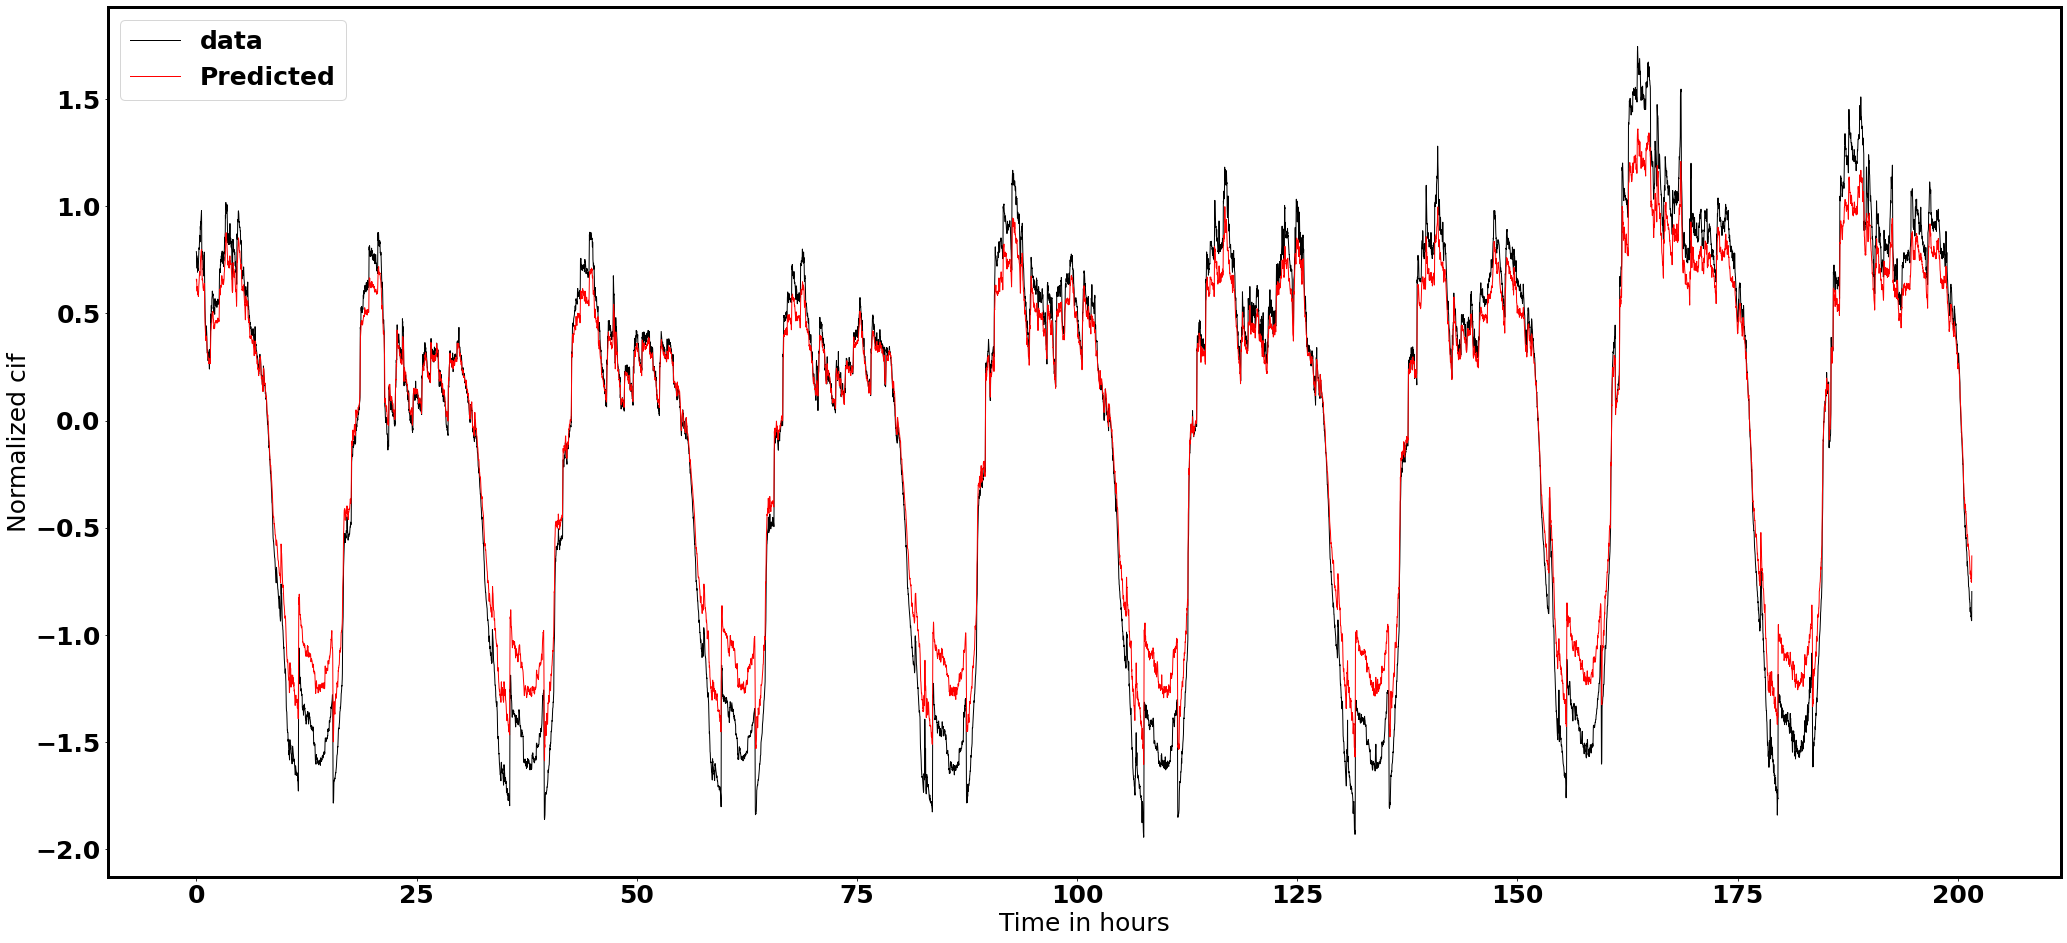

In [54]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"k",label="data",alpha=1,linewidth=1)
plt.plot(timeline/60,y_pre[:,0],"r",label="Predicted",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "CNN_1D_results" + ".png"

fig.savefig(save_path, dpi=150)






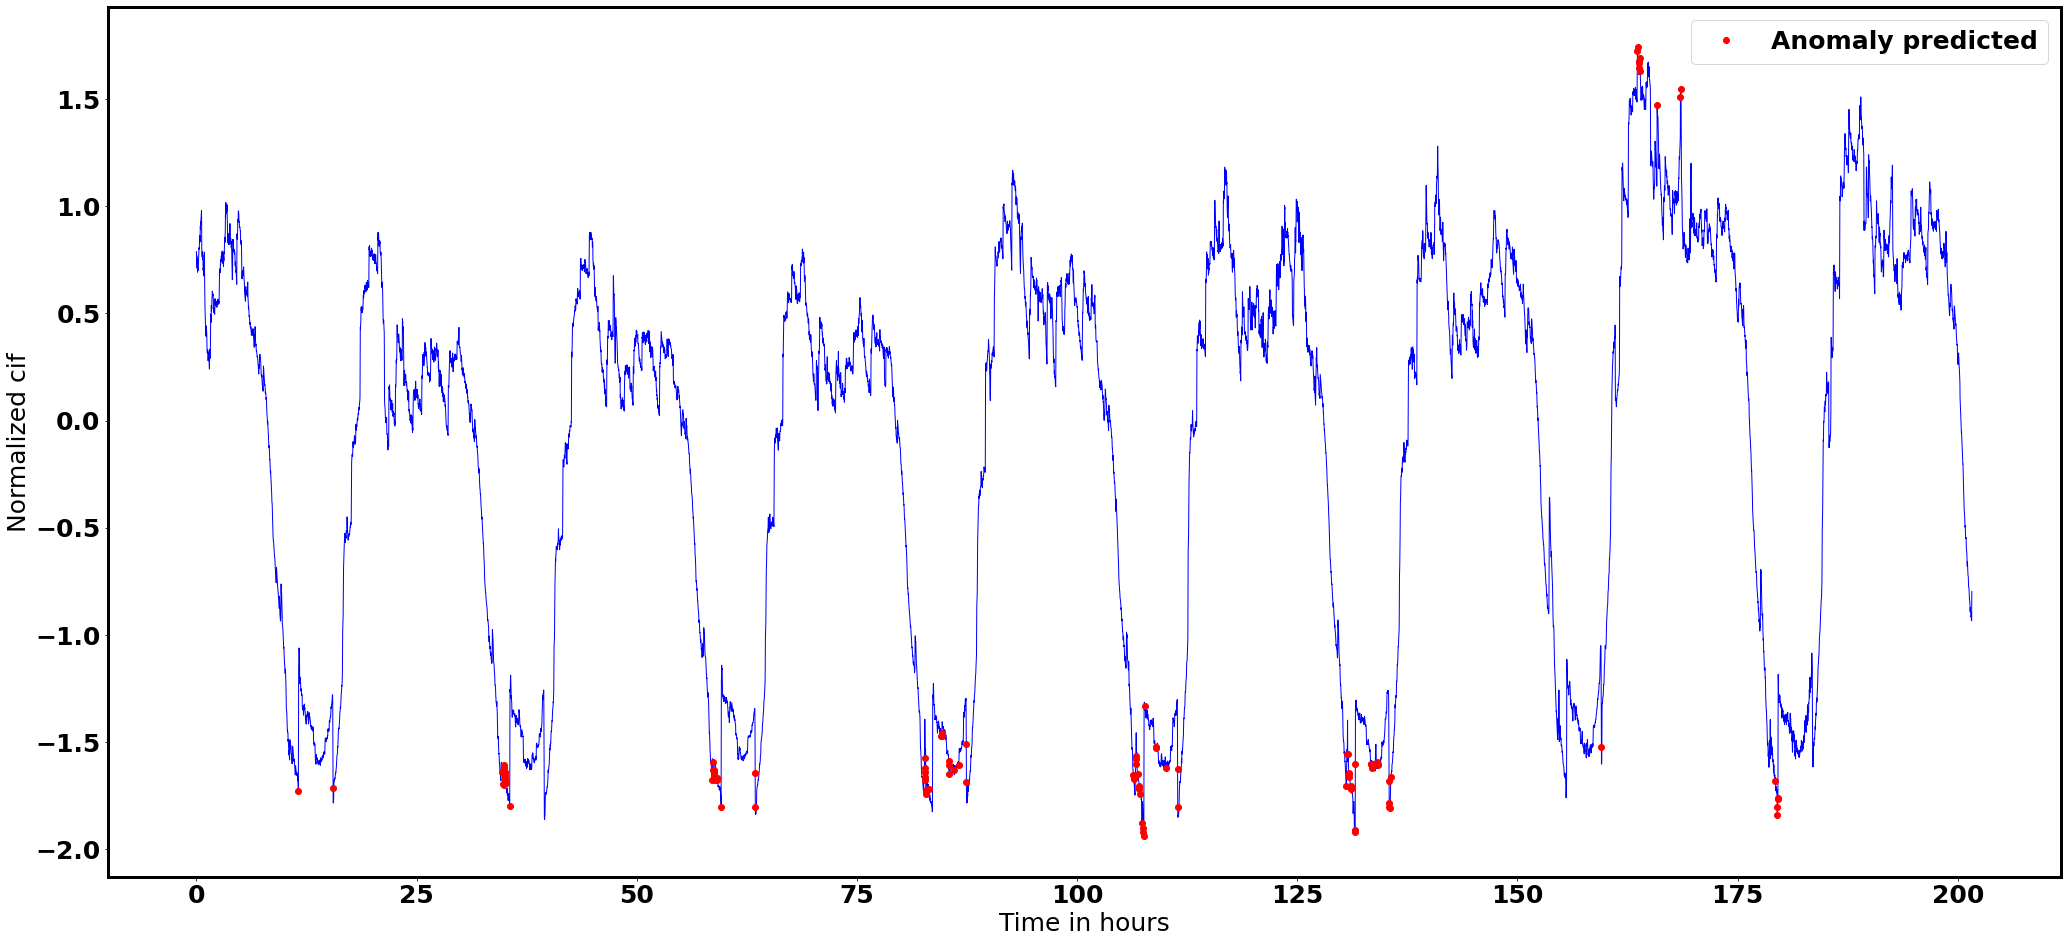

In [56]:
# Predict Anomaly using this rule: Bigger difference between data and prediction means anomaly

diff = y_test-y_pre[:,0]
anomaly_ratio = 0.01
mask = abs(diff)>np.nanpercentile(abs(diff),100-100*anomaly_ratio)



font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"b",alpha=1,linewidth=1)
plt.plot(timeline[mask]/60,y_test[mask],"ro",label="Anomaly predicted CNN",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "CNN_1D_anomaly_prediction" + ".png"

fig.savefig(save_path, dpi=150)







## LSTM with high low open close:
Idea from this: Stock Market Forecasting Using Hidden Markov Model: A New Approach

In [91]:
df["minutes"]=df["time_stamp"].dt.hour*1440+df["time_stamp"].dt.hour*60+df["time_stamp"].dt.minute
# hyper-parameters:
# delta_t in minute,try a day first,output 5 dimensions
delta_t = 1440
n_epoch=10
n_cell = 50
# predict 1 minute for now
N_output=1
index_name= 0

checkpoint_path = "LSTM/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

min_max_scaler = preprocessing.StandardScaler()

name_mod = [names_array[index_name],names_array[index_name]+"_open",names_array[index_name]+"_close",names_array[index_name]+"_max",names_array[index_name]+"_min",]

np_scaled = min_max_scaler.fit_transform(df[name_mod])

df_scaled = pd.DataFrame(np_scaled,columns=name_mod)


X = np.zeros((df_scaled.shape[0]-delta_t,delta_t,5),dtype=float)
y = df_scaled[names_array[index_name]][delta_t:]

for i in range(len(y)):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = df_scaled[i:i+delta_t][name_mod].values

# split train test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

model = tf.keras.Sequential([
  tf.keras.layers.LSTM(n_cell,input_shape=(X_train.shape[1],X_train.shape[2])),  # must declare input shape
  tf.keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer='adam')
#model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)






In [93]:

history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)






Epoch 1/10
441/441 [==============================] - ETA: 0s - loss: 0.0599
Epoch 00001: saving model to LSTM/cp.ckpt
441/441 [==============================] - 48s 109ms/step - loss: 0.0599 - val_loss: 0.0329
Epoch 2/10
441/441 [==============================] - ETA: 0s - loss: 0.0298
Epoch 00002: saving model to LSTM/cp.ckpt
441/441 [==============================] - 49s 110ms/step - loss: 0.0298 - val_loss: 0.0263
Epoch 3/10
441/441 [==============================] - ETA: 0s - loss: 0.0257
Epoch 00003: saving model to LSTM/cp.ckpt
441/441 [==============================] - 46s 105ms/step - loss: 0.0257 - val_loss: 0.0242
Epoch 4/10
441/441 [==============================] - ETA: 0s - loss: 0.0232
Epoch 00004: saving model to LSTM/cp.ckpt
441/441 [==============================] - 47s 106ms/step - loss: 0.0232 - val_loss: 0.0230
Epoch 5/10
441/441 [==============================] - ETA: 0s - loss: 0.0209
Epoch 00005: saving model to LSTM/cp.ckpt
441/441 [============================

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


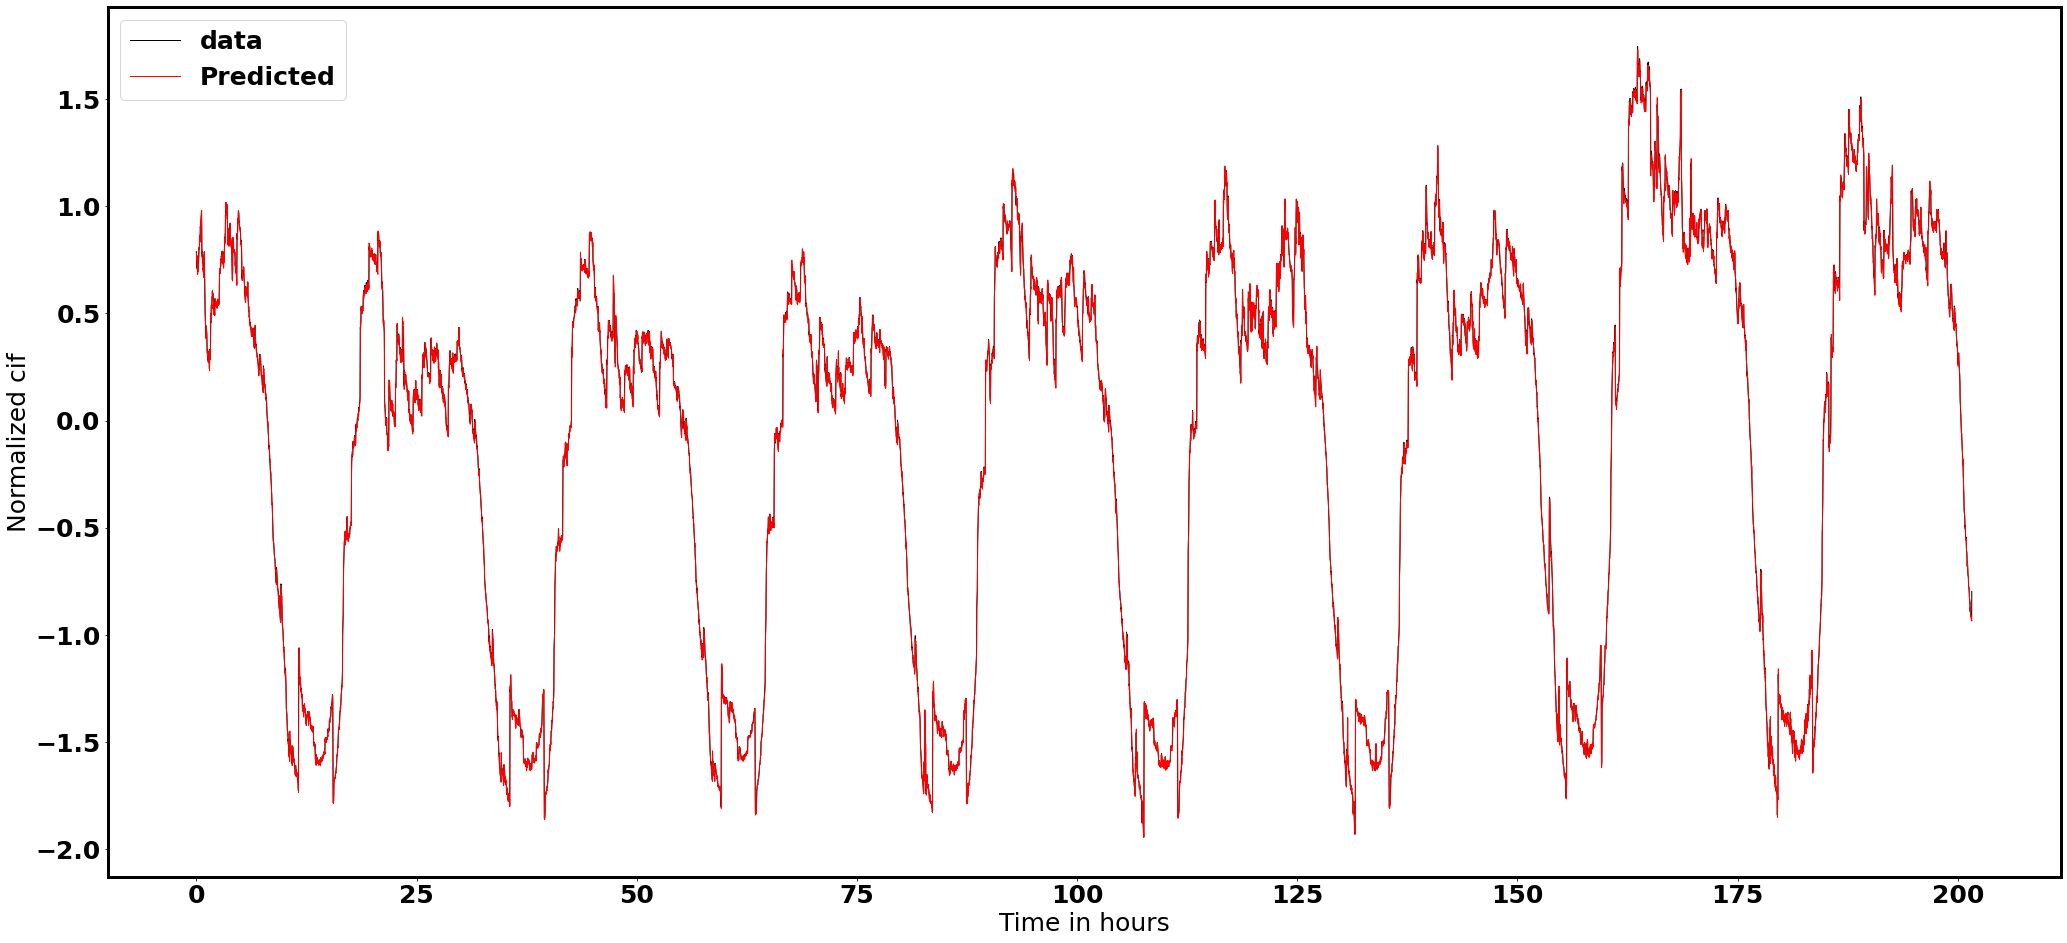

In [94]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
y_pre = model.predict(X_test)
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"k",label="data",alpha=1,linewidth=1)
plt.plot(timeline/60,y_pre[:,0],"r",label="Predicted",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "LSTM_results_5D" + ".png"

fig.savefig(save_path, dpi=150)







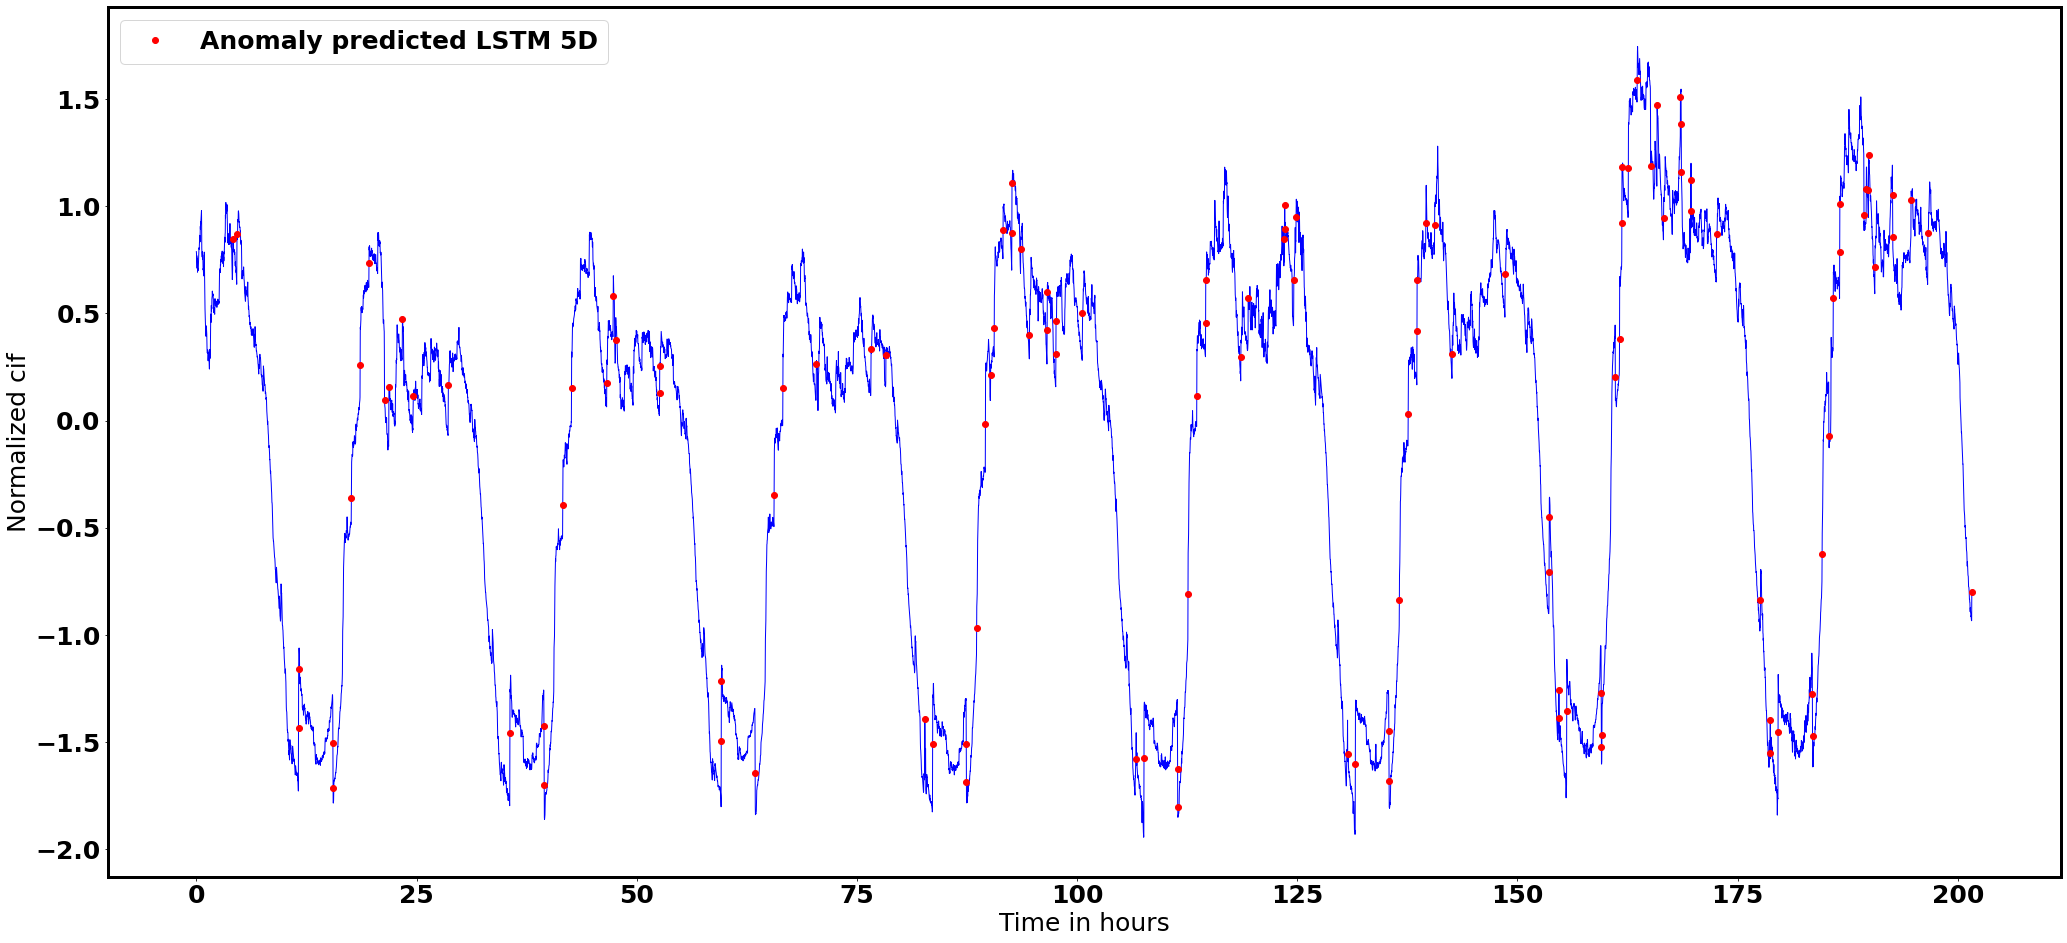

In [95]:
# Predict Anomaly using this rule: Bigger difference between data and prediction means anomaly

diff = y_test-y_pre[:,0]
anomaly_ratio = 0.01
mask = abs(diff)>np.nanpercentile(abs(diff),100-100*anomaly_ratio)



font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"b",alpha=1,linewidth=1)
plt.plot(timeline[mask]/60,y_test[mask],"ro",label="Anomaly predicted LSTM 5D",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "LSTM_anomaly_prediction_5D" + ".png"

fig.savefig(save_path, dpi=150)








In [57]:
# GRU simple
df["minutes"]=df["time_stamp"].dt.hour*1440+df["time_stamp"].dt.hour*60+df["time_stamp"].dt.minute
# hyper-parameters:
# delta_t in minute,try a day first,output 5 dimensions
delta_t = 1440
n_epoch=10
n_cell = 50
# predict 1 minute for now
N_output=1
index_name= 0

checkpoint_path = "LSTM/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

min_max_scaler = preprocessing.StandardScaler()

# min-max scaler
np_scaled = min_max_scaler.fit_transform(df[names_array])

df_scaled = pd.DataFrame(np_scaled,columns=names_array)


X = np.zeros((df_scaled.shape[0]-delta_t,delta_t,1),dtype=float)
y = df_scaled[names_array[index_name]][delta_t:]
    
for i in range(len(y)):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = np.atleast_2d(df_scaled[i:i+delta_t][names_array[index_name]].values).T

# split train test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

model = tf.keras.Sequential([
  tf.keras.layers.GRU(n_cell,input_shape=(X_train.shape[1],X_train.shape[2])),  # must declare input shape
  tf.keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer='adam')
#model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)





Prepare data 0.00 percent
Prepare data 24.80 percent
Prepare data 49.60 percent
Prepare data 74.40 percent
Prepare data 99.20 percent
Epoch 1/10
441/441 [==============================] - ETA: 0s - loss: 0.0762
Epoch 00001: saving model to LSTM/cp.ckpt
441/441 [==============================] - 48s 109ms/step - loss: 0.0762 - val_loss: 0.0258
Epoch 2/10
441/441 [==============================] - ETA: 0s - loss: 0.0231
Epoch 00002: saving model to LSTM/cp.ckpt
441/441 [==============================] - 49s 110ms/step - loss: 0.0231 - val_loss: 0.0210
Epoch 3/10
441/441 [==============================] - ETA: 0s - loss: 0.0202
Epoch 00003: saving model to LSTM/cp.ckpt
441/441 [==============================] - 49s 111ms/step - loss: 0.0202 - val_loss: 0.0187
Epoch 4/10
441/441 [==============================] - ETA: 0s - loss: 0.0189
Epoch 00004: saving model to LSTM/cp.ckpt
441/441 [==============================] - 48s 108ms/step - loss: 0.0189 - val_loss: 0.0185
Epoch 5/10
441/441 [==

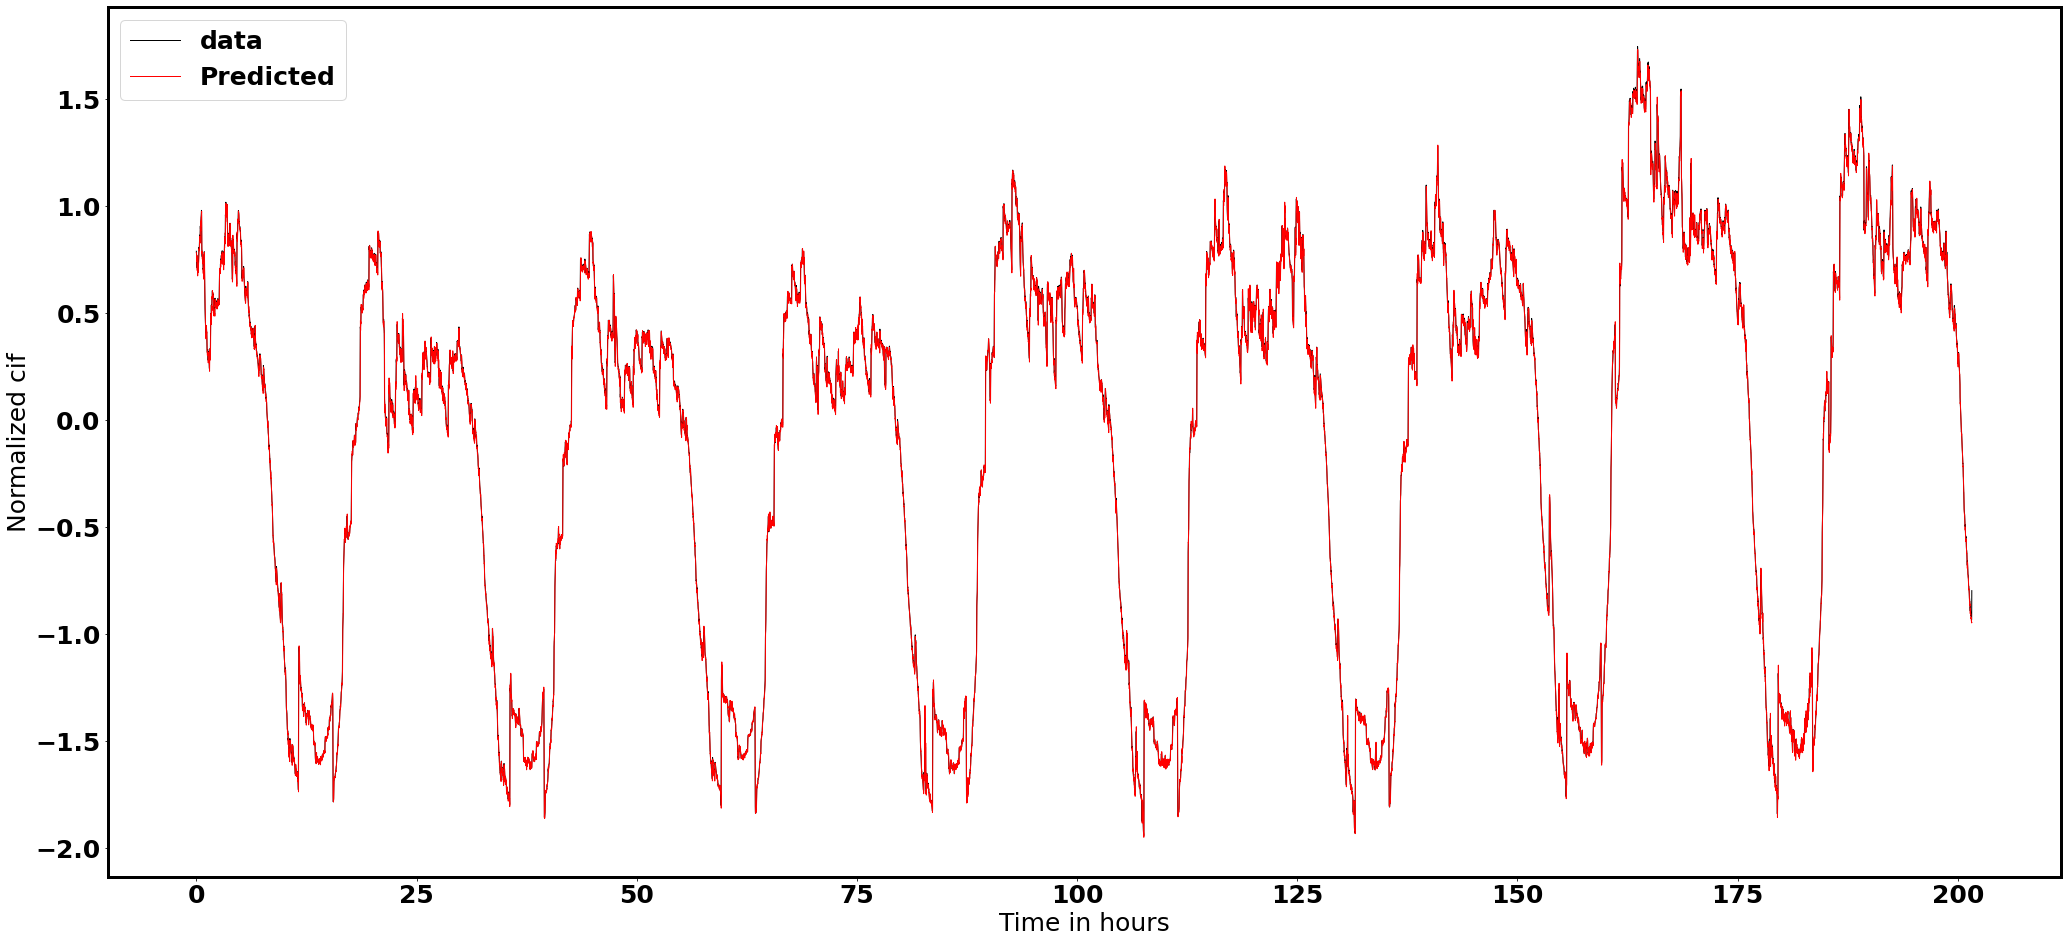

In [58]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
y_pre = model.predict(X_test)
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"k",label="data",alpha=1,linewidth=1)
plt.plot(timeline/60,y_pre[:,0],"r",label="Predicted",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "GRU_results_1D" + ".png"

fig.savefig(save_path, dpi=150)






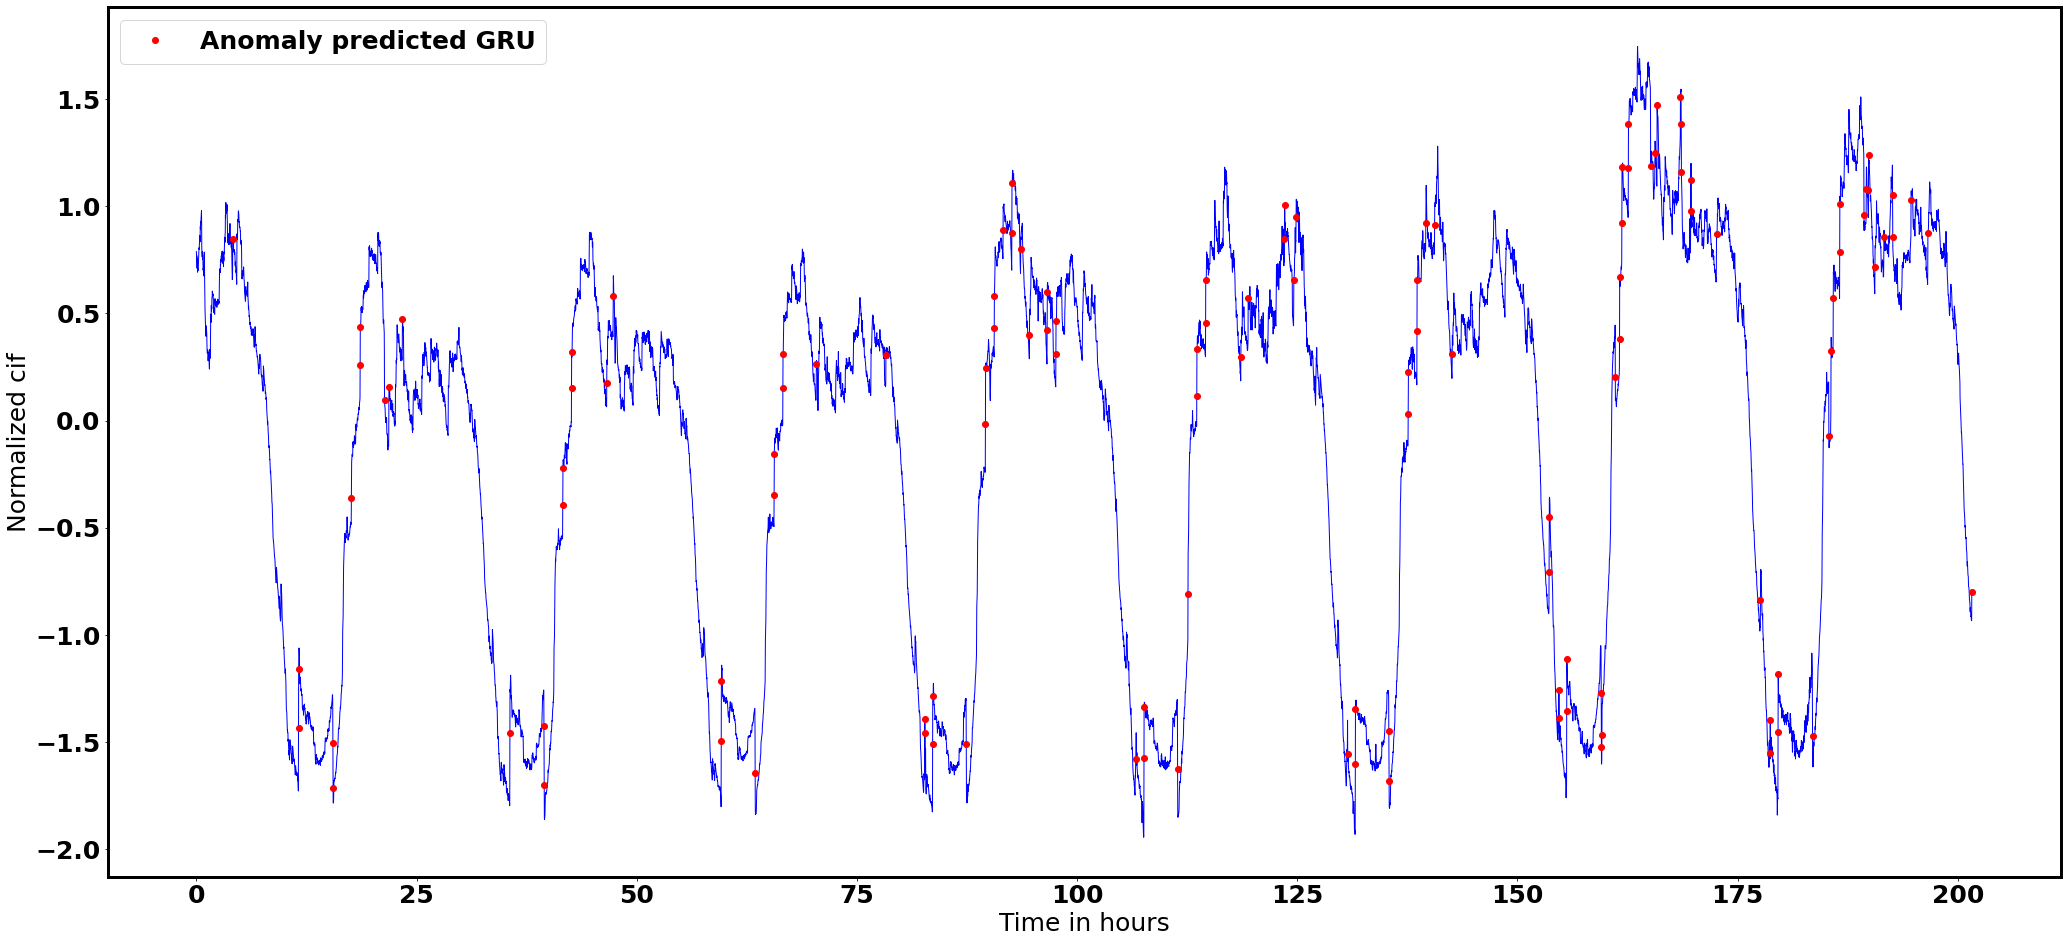

In [60]:
# Predict Anomaly using this rule: Bigger difference between data and prediction means anomaly

diff = y_test-y_pre[:,0]
anomaly_ratio = 0.01
mask = abs(diff)>np.nanpercentile(abs(diff),100-100*anomaly_ratio)



font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"b",alpha=1,linewidth=1)
plt.plot(timeline[mask]/60,y_test[mask],"ro",label="Anomaly predicted GRU",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "GRU_anomaly_prediction_1D" + ".png"

fig.savefig(save_path, dpi=150)







In [98]:
#  GRU+ 1D CNN:
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
df["minutes"]=df["time_stamp"].dt.hour*1440+df["time_stamp"].dt.hour*60+df["time_stamp"].dt.minute
# hyper-parameters:
# delta_t in minute,try a day first,output 5 dimensions
delta_t = 1440
n_epoch=10
n_cell = 50
# predict 1 minute for now
N_output=1
index_name= 0
rate_dropout = 0.2

checkpoint_path = "LSTM/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

min_max_scaler = preprocessing.StandardScaler()

# min-max scaler
np_scaled = min_max_scaler.fit_transform(df[names_array])

df_scaled = pd.DataFrame(np_scaled,columns=names_array)


X = np.zeros((df_scaled.shape[0]-delta_t,delta_t,1),dtype=float)
y = df_scaled[names_array[index_name]][delta_t:]
    
for i in range(len(y)):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = np.atleast_2d(df_scaled[i:i+delta_t][names_array[index_name]].values).T

# split train test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)




Prepare data 0.00 percent
Prepare data 24.80 percent
Prepare data 49.60 percent
Prepare data 74.40 percent
Prepare data 99.20 percent


In [125]:

model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(n_cell,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(tf.keras.layers.Dense(100))
model.add(Dropout(rate_dropout))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 50)                7950      
_________________________________________________________________
dense_9 (Dense)              (None, 100)               5100      
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 13,151
Trainable params: 13,151
Non-trainable params: 0
_________________________________________________________________


In [126]:

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)





Epoch 1/10
441/441 [==============================] - ETA: 0s - loss: 0.0688
Epoch 00001: saving model to LSTM/cp.ckpt
441/441 [==============================] - 48s 108ms/step - loss: 0.0688 - val_loss: 0.0200
Epoch 2/10
441/441 [==============================] - ETA: 0s - loss: 0.0457
Epoch 00002: saving model to LSTM/cp.ckpt
441/441 [==============================] - 48s 108ms/step - loss: 0.0457 - val_loss: 0.0257
Epoch 3/10
441/441 [==============================] - ETA: 0s - loss: 0.0442
Epoch 00003: saving model to LSTM/cp.ckpt
441/441 [==============================] - 48s 109ms/step - loss: 0.0442 - val_loss: 0.0208
Epoch 4/10
441/441 [==============================] - ETA: 0s - loss: 0.0443
Epoch 00004: saving model to LSTM/cp.ckpt
441/441 [==============================] - 46s 104ms/step - loss: 0.0443 - val_loss: 0.0198
Epoch 5/10
441/441 [==============================] - ETA: 0s - loss: 0.0438
Epoch 00005: saving model to LSTM/cp.ckpt
441/441 [============================

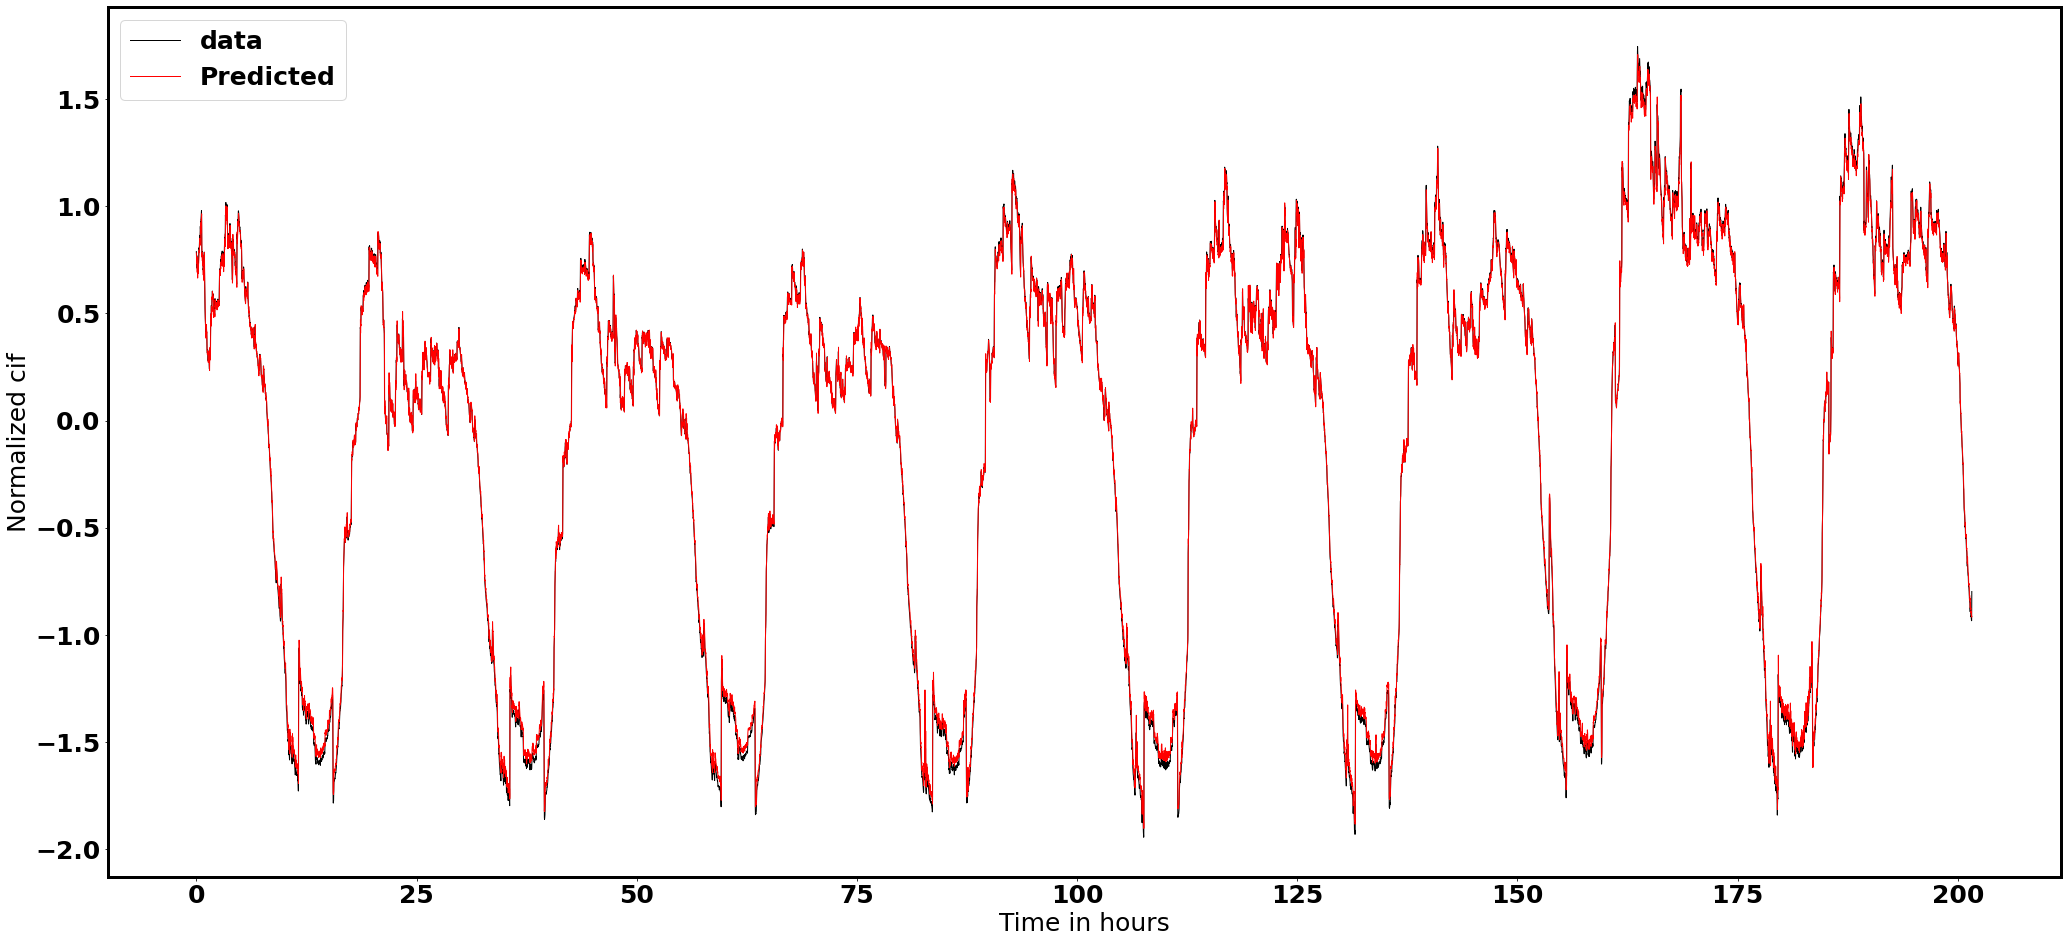

In [128]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
y_pre = model.predict(X_test)
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"k",label="data",alpha=1,linewidth=1)
plt.plot(timeline/60,y_pre[:,0],"r",label="Predicted",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "GRU_NN_results_1D" + ".png"

fig.savefig(save_path, dpi=150)







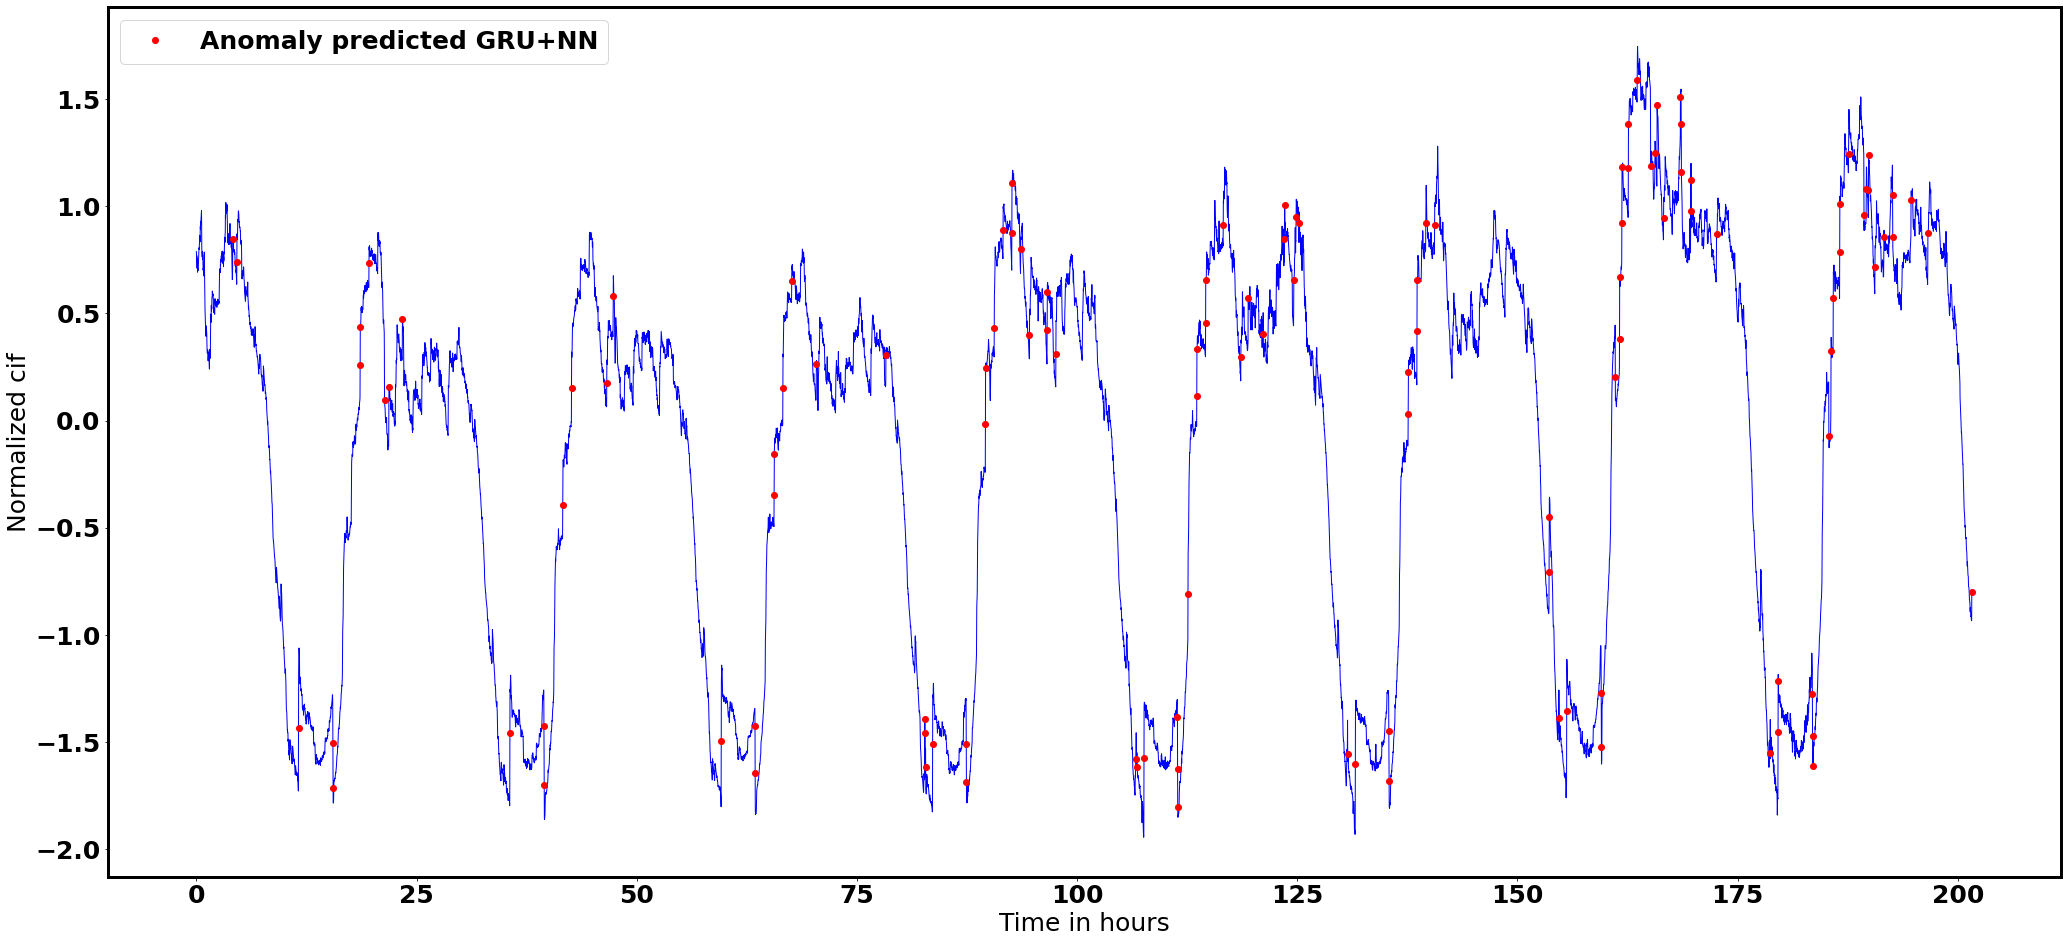

In [129]:
# Predict Anomaly using this rule: Bigger difference between data and prediction means anomaly

diff = y_test-y_pre[:,0]
anomaly_ratio = 0.01
mask = abs(diff)>np.nanpercentile(abs(diff),100-100*anomaly_ratio)



font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"b",alpha=1,linewidth=1)
plt.plot(timeline[mask]/60,y_test[mask],"ro",label="Anomaly predicted GRU+NN",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "GRU_NN_anomaly_prediction_1D" + ".png"

fig.savefig(save_path, dpi=150)








## MLSTM-FCN:
https://arxiv.org/pdf/1709.05206.pdf

In [5]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout

In [65]:
# hyper-parameters:
# delta_t in minute,try a day first,output 5 dimensions
delta_t = 1440
n_epoch=40
n_cell = 50
# predict 1 minute for now
N_output=1
N_input = 5
index_name= 0

In [66]:

NB_CLASS = 1

def squeeze_excite_block(input):

    filters = input._shape[-1] # channel_axis = -1 for TF

    se = GlobalAveragePooling1D()(input)
    se = Reshape((1, filters))(se)
    se = Dense(filters // 16,  activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = multiply([input, se])
    return se

def generate_model(MAX_TIMESTEPS,MAX_NB_VARIABLES):
    ip = Input(shape=(MAX_TIMESTEPS,MAX_NB_VARIABLES))
    # split into x and y two channels

    x = Masking()(ip)
    x = LSTM(n_cell)(x)
    x = Dropout(0.8)(x)

    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)

    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)
    # combine
    x = concatenate([x, y])

    #out = Dense(NB_CLASS, activation='softmax')(x)
    # For regression model use MAE
    out = Dense(N_output)(x)

    model = Model(ip, out)
    model.summary()

    # add load model code here to fine-tune

    return model

In [67]:
#model = generate_model(1440,5)

In [68]:
df["minutes"]=df["time_stamp"].dt.hour*1440+df["time_stamp"].dt.hour*60+df["time_stamp"].dt.minute


checkpoint_path = "LSTM/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

min_max_scaler = preprocessing.StandardScaler()

name_mod = [names_array[index_name],names_array[index_name]+"_open",names_array[index_name]+"_close",names_array[index_name]+"_max",names_array[index_name]+"_min",]

np_scaled = min_max_scaler.fit_transform(df[name_mod])

df_scaled = pd.DataFrame(np_scaled,columns=name_mod)


X = np.zeros((df_scaled.shape[0]-delta_t,delta_t,5),dtype=float)
y = df_scaled[names_array[index_name]][delta_t:]

for i in range(len(y)):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = df_scaled[i:i+delta_t][name_mod].values

# split train test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

model = generate_model(1440,5)

model.compile(loss='mae', optimizer='adam')
#model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)





Prepare data 0.00 percent
Prepare data 24.80 percent
Prepare data 49.60 percent
Prepare data 74.40 percent
Prepare data 99.20 percent
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 1440, 5)]    0                                            
__________________________________________________________________________________________________
permute_17 (Permute)            (None, 5, 1440)      0           input_18[0][0]                   
__________________________________________________________________________________________________
conv1d_41 (Conv1D)              (None, 5, 128)       1474688     permute_17[0][0]                 
__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 5, 128)       512

In [69]:

history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)



Epoch 1/40
441/441 [==============================] - ETA: 0s - loss: 0.1741
Epoch 00001: saving model to LSTM/cp.ckpt
441/441 [==============================] - 42s 96ms/step - loss: 0.1741 - val_loss: 0.1478
Epoch 2/40
441/441 [==============================] - ETA: 0s - loss: 0.1105
Epoch 00002: saving model to LSTM/cp.ckpt
441/441 [==============================] - 41s 94ms/step - loss: 0.1105 - val_loss: 0.1063
Epoch 3/40
441/441 [==============================] - ETA: 0s - loss: 0.0983
Epoch 00003: saving model to LSTM/cp.ckpt
441/441 [==============================] - 42s 94ms/step - loss: 0.0983 - val_loss: 0.0693
Epoch 4/40
441/441 [==============================] - ETA: 0s - loss: 0.0865
Epoch 00004: saving model to LSTM/cp.ckpt
441/441 [==============================] - 42s 94ms/step - loss: 0.0865 - val_loss: 0.0637
Epoch 5/40
441/441 [==============================] - ETA: 0s - loss: 0.0799
Epoch 00005: saving model to LSTM/cp.ckpt
441/441 [==============================] 

Epoch 40/40
441/441 [==============================] - ETA: 0s - loss: 0.0320
Epoch 00040: saving model to LSTM/cp.ckpt
441/441 [==============================] - 42s 94ms/step - loss: 0.0320 - val_loss: 0.0369


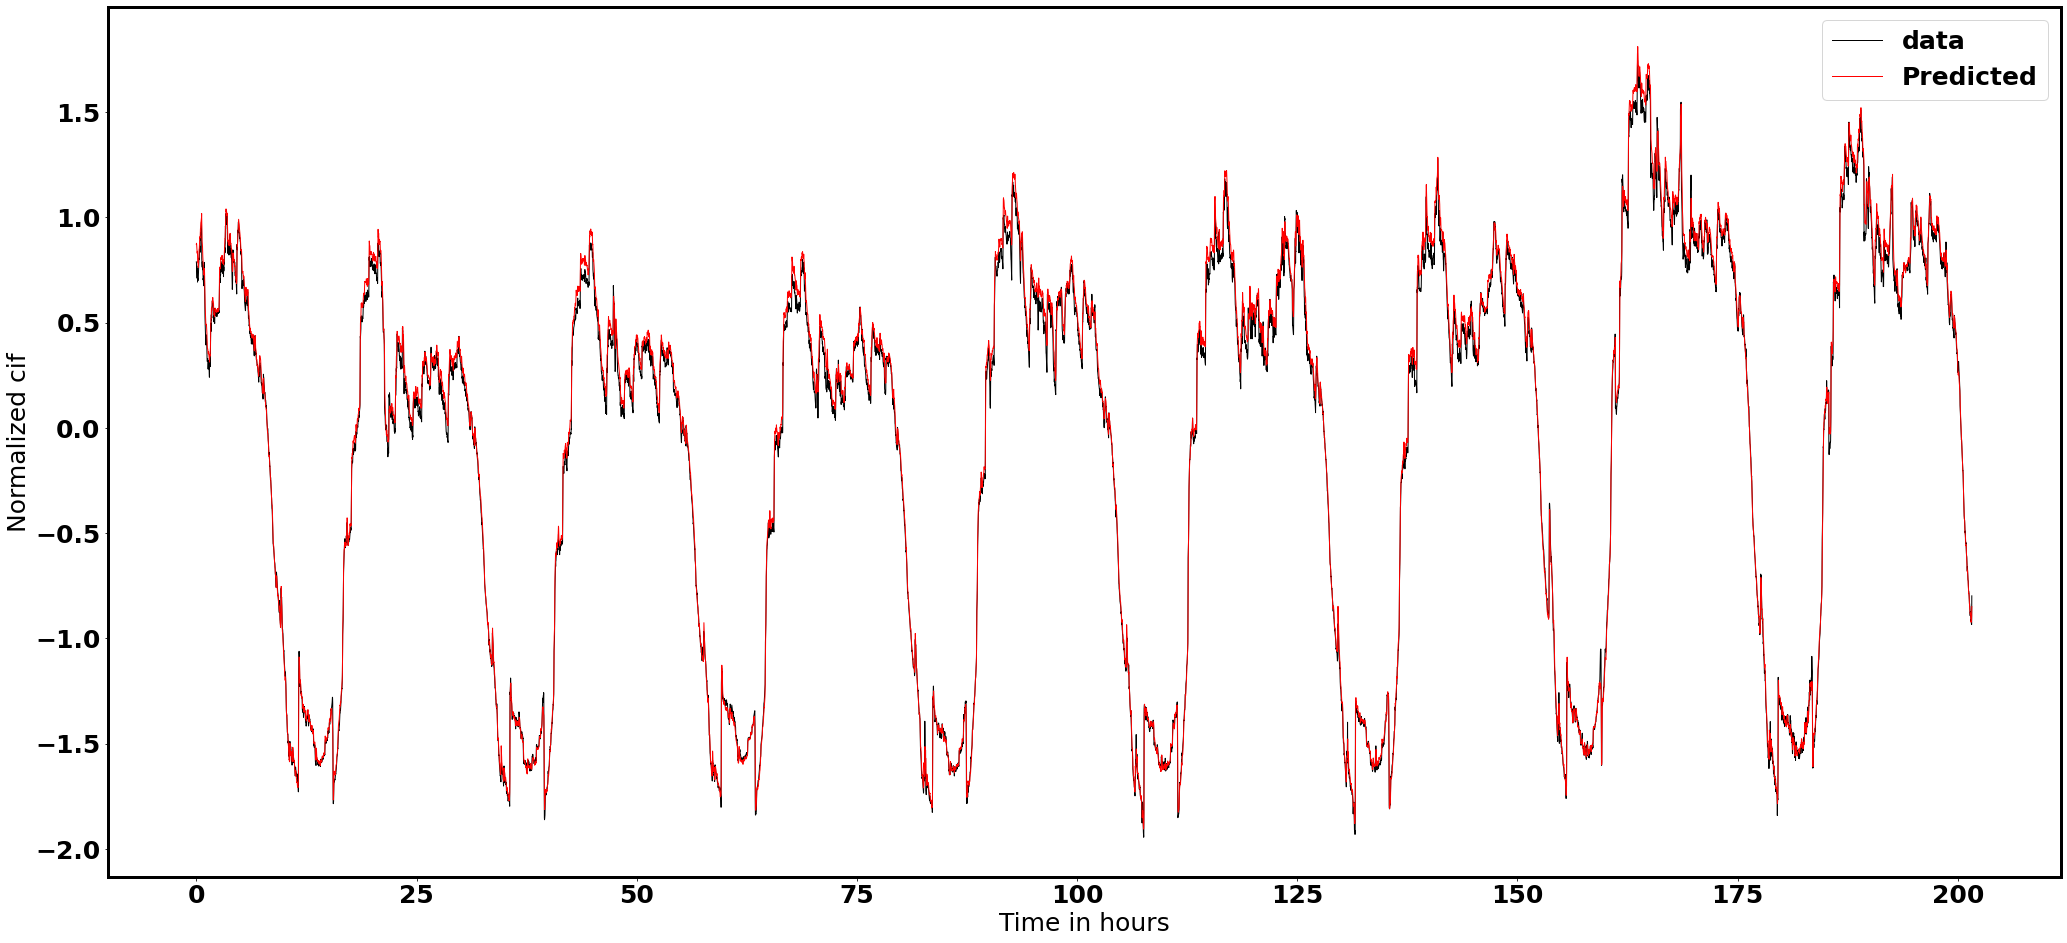

In [70]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
y_pre = model.predict(X_test)
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"k",label="data",alpha=1,linewidth=1)
plt.plot(timeline/60,y_pre[:,0],"r",label="Predicted",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "MLSTM_FCN_results_5D" + ".png"

fig.savefig(save_path, dpi=150)








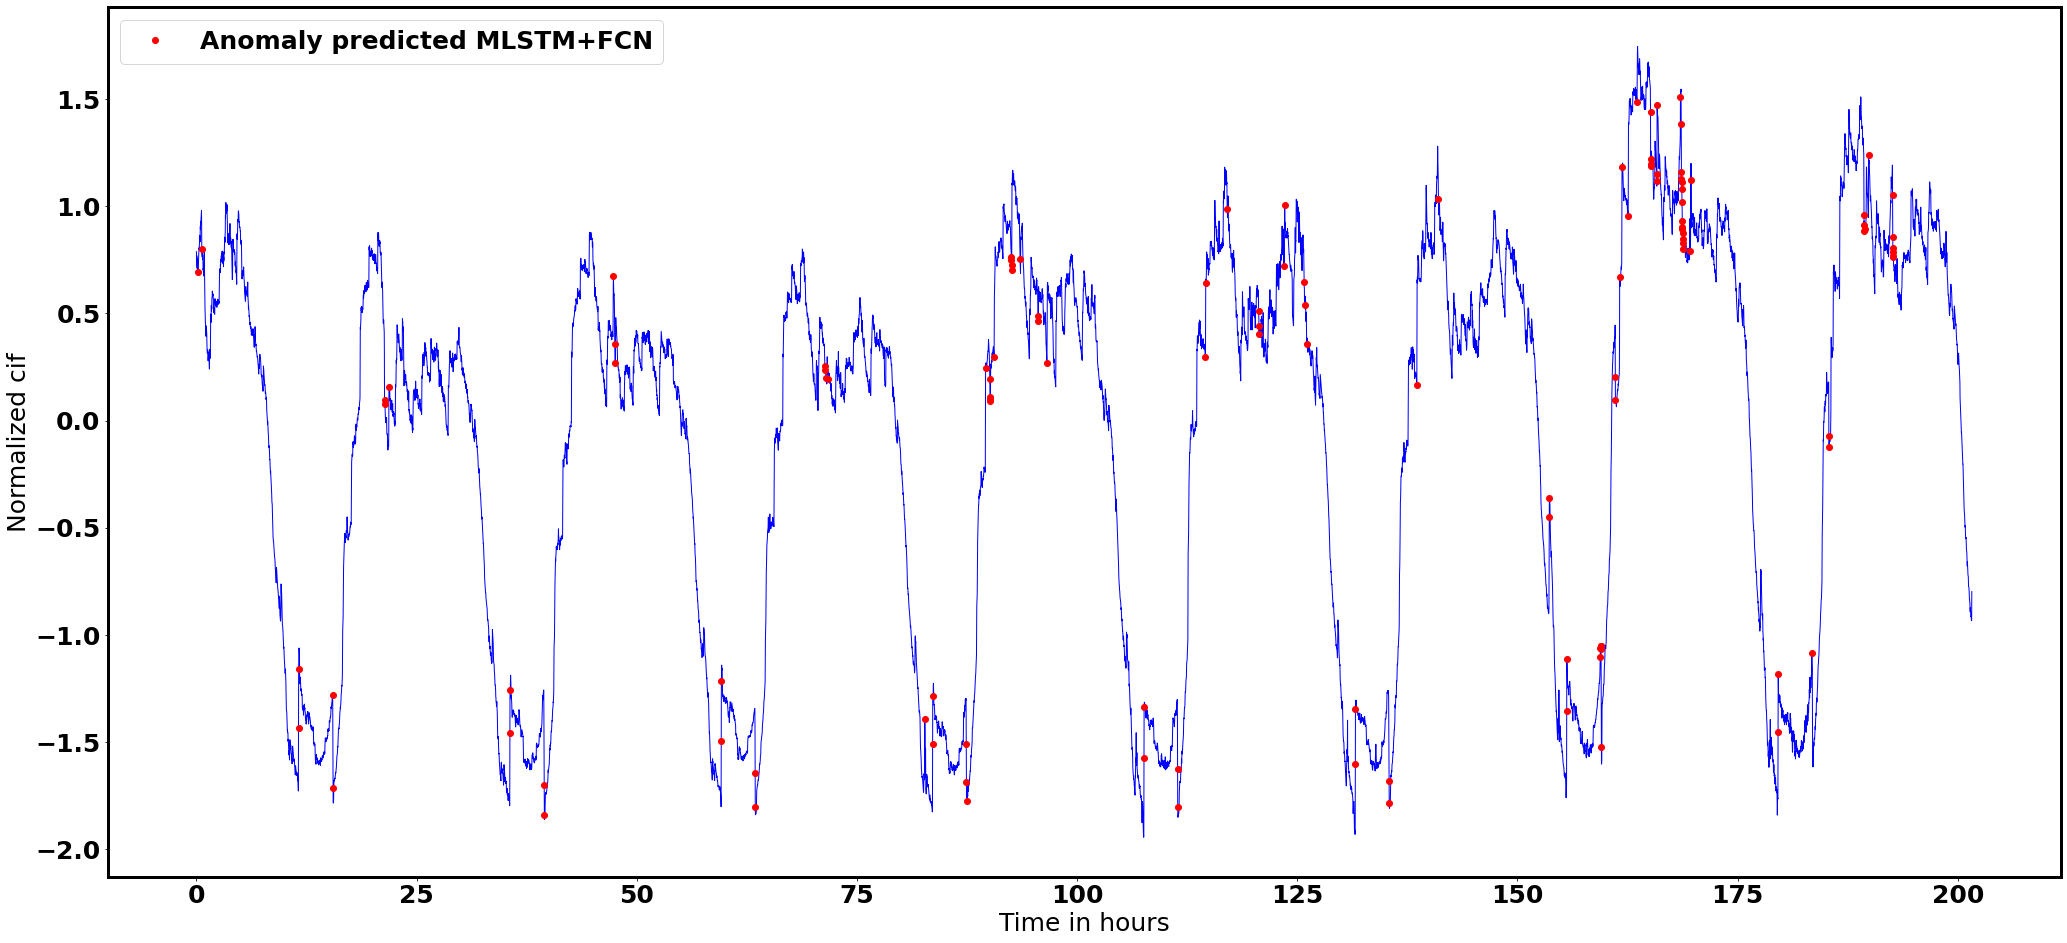

In [71]:
# Predict Anomaly using this rule: Bigger difference between data and prediction means anomaly

diff = y_test-y_pre[:,0]
anomaly_ratio = 0.01
mask = abs(diff)>np.nanpercentile(abs(diff),100-100*anomaly_ratio)



font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"b",alpha=1,linewidth=1)
plt.plot(timeline[mask]/60,y_test[mask],"ro",label="Anomaly predicted MLSTM+FCN",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "MLSTM_FCN_anomaly_prediction_5D" + ".png"

fig.savefig(save_path, dpi=150)









In [72]:
print("Done")

Done


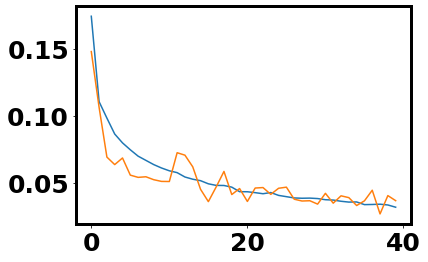

In [73]:
# Only for diagnostic
plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['val_loss'],label="Val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()